# SARSA Frozen Lake
Implementation of a SARSA agent to learn policies in the Frozen Lake environment from OpenAI gym.

In [1]:
# define path
RESULT_IMG_PATH = 'img/result_img_{}.png'

In [2]:
# import dependency
import gym # OpenAI Game Environment
import gym.envs.toy_text # Customized Map
import numpy as np
from tqdm import trange # Processing Bar
import matplotlib.pyplot as plt
%matplotlib inline

## Problem - Frozen Lake

[Frozen Lake](https://gym.openai.com/envs/FrozenLake-v0/) This setting involves an environment where an agent maneuvers a character within a grid-based world. Beginning at the starting point *S*, the agent's objective is to navigate the character to the designated goal state *G* to receive a reward of 1. However, the agent faces a challenge as it encounters the slippery frozen state *F*, reducing its success rate to $\frac{1}{3}$ for each action. The agent's movements are distributed evenly among the four possible actions (*left*, *down*, *right*, *up*) for the remaining $\frac{2}{3}$ of the time. Moreover, entering a hole state *H* results in an undesirable outcome with a reward of 0.

Symbols:
+ S: Start State
+ G: Goal State
+ F: Frozen Surface
+ H: Hole State

In [7]:
# initialization
amap='SFFFHFFFG'
grid_shape = int(np.sqrt(len(amap)))  # Use int function to convert to integer
custom_map = np.array(list(amap)).reshape(grid_shape, grid_shape)
env = gym.envs.toy_text.frozen_lake.FrozenLakeEnv(desc=custom_map).unwrapped
# env = gym.make('FrozenLake-v0')
n_states, n_actions = env.observation_space.n, env.action_space.n
print('{} states'.format(n_states))
print('{} actions'.format(n_actions))
#env.render() 


9 states
4 actions


In [9]:
# take a look
done = False
env.reset()
while not done:
    # randomly pick an action
    action = np.random.randint(n_actions)
    # get feedback from the environment
    obvervation, reward, done, info = env.step(action)
    # show the environment
    env.render()

## State Action Reward State Action (SARSA)

The State-Action-Reward-State-Action (SARSA) method is a renowned approach in reinforcement learning for solving Markov Decision Processes (MDPs). As its name suggests, SARSA updates the Q-value, denoted by $Q(s_{t}, a_{t})$, based on the current state $s_{t}$, the chosen action $a_{t}$, the resulting reward $r_{t}$, the subsequent state $s_{t+1}$ after executing the action, and the action $a_{t+1}$ selected for the new state. 

The update equation for the Q-value table is given by:

$$Q(s_{t}, a_{t}) \leftarrow Q(s_{t}, a_{t}) + \alpha[r_{t} + \gamma Q(s_{t+1}, a_{t+1}) - Q(s_{t}, a_{t})]$$

Here, $\alpha$ denotes the learning rate and $\gamma$ represents the discount factor. It's evident from this definition that SARSA operates by iteratively refining the policy through interactions with the environment, making it part of the on-policy learning algorithm category.

### Training

In [32]:
# initialize the agent’s Q-table to zeros
def init_q(s, a):
    """
    s: number of states
    a: number of actions
    """
    return np.zeros((s, a))

# epsilon-greedy exploration strategy
def epsilon_greedy(Q, epsilon, n_actions, s):
    """
    Q: Q Table
    epsilon: exploration parameter
    n_actions: number of actions
    s: state
    """
    # selects a random action with probability epsilon
    if np.random.random() <= epsilon:
        return np.random.randint(n_actions)
    else:
        return np.argmax(Q[s, :])
    
# SARSA Process
def sarsa(alpha, gamma, epsilon, n_episodes):
    """
    alpha: learning rate
    gamma: exploration parameter
    n_episodes: number of episodes
    """
    # initialize Q table
    Q = init_q(n_states, n_actions)
    t = trange(n_episodes)
    reward_array = np.zeros(n_episodes)
    for i in t:
        # initial state
        s = env.reset()
        # initial action
        a = epsilon_greedy(Q, epsilon, n_actions, s)
        done = False
        while not done:
            s_, reward, done, _ = env.step(a)
            a_ = epsilon_greedy(Q, epsilon, n_actions, s_)
            # update Q table
            Q[s, a] += alpha * (reward + (gamma * Q[s_, a_]) - Q[s, a])
            if done:
                t.set_description('Episode {} Reward {}'.format(i + 1, reward))
                t.refresh()
                reward_array[i] = reward
                break
            s, a = s_, a_
    env.close()
    return Q, reward_array

In [39]:
# experiment settings
alpha = 0.1 # learning rate
gamma = 0.9 # discount factor
epsilon=0.5 # exploration parameter
n_episodes = 1000 # number of training episodes

In [40]:
# training
Q, reward_array = sarsa(alpha, gamma, epsilon, n_episodes)

Episode 1000 Reward 0.0: 100%|██████████| 1000/1000 [00:04<00:00, 220.63it/s]


In [41]:
# show Q table
Q

array([[0.11132825, 0.12229354, 0.11785264, 0.11118883],
       [0.08042749, 0.14024655, 0.13474026, 0.16478976],
       [0.28550722, 0.26150698, 0.25293918, 0.23521373],
       [0.13035875, 0.12688529, 0.12116299, 0.07614327],
       [0.        , 0.        , 0.        , 0.        ],
       [0.49949557, 0.2939676 , 0.51924078, 0.31975318],
       [0.23218791, 0.36976288, 0.25418872, 0.31231136],
       [0.18482756, 0.43804349, 0.44799121, 0.55700009],
       [0.        , 0.        , 0.        , 0.        ]])

In [42]:
# averaged reward per episode
avg_reward = round(np.mean(reward_array), 4)
print('Averaged reward per episode {}'.format(avg_reward))

Averaged reward per episode 0.335


### Testing

In [43]:
def eva(Q, n_episodes):
    """
    Q: trained Q table
    n_episodes: number of episodes
    """
    t = trange(n_episodes)
    reward_array = np.zeros(n_episodes)
    for i in t:
        # initial state
        s = env.reset()
        # initial action
        a = np.argmax(Q[s])
        done = False
        while not done:
            s_, reward, done, _ = env.step(a)
            # pick an action according the state and trained Q table
            a_ = np.argmax(Q[s_])
            if done:
                t.set_description('Episode {} Reward {}'.format(i + 1, reward))
                t.refresh()
                reward_array[i] = reward
                break
            s, a = s_, a_
    env.close()
    return reward_array

In [44]:
# experiment settings
n_episodes = 100 # number of testing episodes
reward_array = eva(Q, n_episodes)

Episode 100 Reward 1.0: 100%|██████████| 100/100 [00:00<00:00, 240.19it/s]


In [45]:
# averaged reward per episode
avg_reward = round(np.mean(reward_array), 4)
print('Averaged reward per episode {}'.format(avg_reward))

Averaged reward per episode 0.58


In [46]:
import os
img_dir = 'img'

# Check if the directory exists, if not, create it
if not os.path.exists(img_dir):
    os.makedirs(img_dir)

# Save the image
plt.savefig(os.path.join(img_dir, 'result_img_1.png'), dpi=100, bbox_inches='tight')

<Figure size 640x480 with 0 Axes>

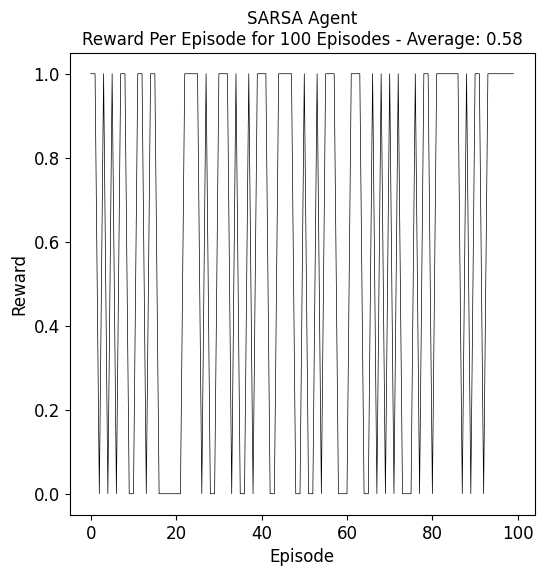

In [47]:
# show reward per episode
plt.subplots(figsize = (6, 6), dpi=100)
plt.plot(reward_array, color='black', linewidth=0.5)
plt.ylabel('Reward', fontsize=12)
plt.xlabel('Episode', fontsize=12)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.title('SARSA Agent\nReward Per Episode for {} Episodes - Average: {:.2f}'.format(n_episodes, avg_reward), 
          fontsize=12)
plt.savefig(RESULT_IMG_PATH.format(1), dpi=100, bbox_inches='tight')
plt.show()

In [48]:
# trained SARSA agent in Frozen Lake
done = False
s = env.reset()
env.render()
while not done:
    # pick an action
    a = np.argmax(Q[s])
    # get feedback from the environment
    s_, _, done, _ = env.step(a)
    # show the environment
    env.render()
    s = s_